### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 3

#### Дисциплина: Интеллектуальный анализ данных

##### Студент: Миронов Дмитрий Андреевич
##### Группа:   НПИ-02-21

## Москва 2024
***

### Вариант № 6

Wine Data Set  

Название файла: wine.data

Ссылка: http://archive.ics.uci.edu/ml/datasets/Wine

Первый признак: alcohol (столбец No 2)

Второй признак: color-intensity (столбец No 11)

Класс: cultivar (столбец No 1)

Алгоритмы: K-means, Agglomerative Clustering, DBSCAN, Gaussian Mixture Model

Меры качества: условная энтропия, парные меры TP, FN, FP, TN, индекс Rand

Найти лучший алгоритм кластеризации относительно меры качества: индекс Rand



1. Считайте из заданного набора данных репозитария UCI значения двух признаков и метки класса.

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [233]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

column_names = ["0","cultivar", "alcohol", "3", "4", "5", "6",
                "7", "8", "9", "10", "color-intensity", "12", "13"]
data = pd.read_csv(url, names = column_names)
data.head()

,0,cultivar,alcohol,3,4,5,6,7,8,9,10,color-intensity,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [234]:
df = data[["cultivar", "alcohol", "color-intensity"]].copy()
df.head()

,cultivar,alcohol,color-intensity
0,14.23,1.71,1.04
1,13.20,1.78,1.05
2,13.16,2.36,1.03
3,14.37,1.95,0.86
4,13.24,2.59,1.04


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cultivar         178 non-null    float64
 1   alcohol          178 non-null    float64
 2   color-intensity  178 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


2. Если среди меток класса имеются пропущенные значения, то удалите записи с пропущенными метками класса. Если в признаках имеются пропущенные значения, то замените их на медианные значения того класса, к которому относится запись с пропущенным значением в признаке.

In [236]:
df = df.replace('?', np.NaN)
df.isnull().sum()

,0
cultivar,0
alcohol,0
color-intensity,0


In [237]:
df.head()

,cultivar,alcohol,color-intensity
0,14.23,1.71,1.04
1,13.20,1.78,1.05
2,13.16,2.36,1.03
3,14.37,1.95,0.86
4,13.24,2.59,1.04


3. Если количество различных меток класса больше пяти, то объедините некоторые (наименее многочисленные) классы, чтобы общее количество классов не превышало пяти.

In [238]:
class_counts = df["cultivar"].value_counts()
class_counts

,count
cultivar,
13.05,6
12.37,6
12.08,5
12.29,4
12.42,3
...,...
13.72,1
13.29,1
13.74,1


In [239]:
len(class_counts)

126

In [240]:
df["cultivar"] = df["cultivar"].apply(lambda x: x if x in class_counts.index[:4] else 0)
df["cultivar"].value_counts()

,count
cultivar,
0.00,157
13.05,6
12.37,6
12.08,5
12.29,4


4. Визуализируйте набор данных в виде точек плоскости с координатами, соответствующими двум признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду набора данных.

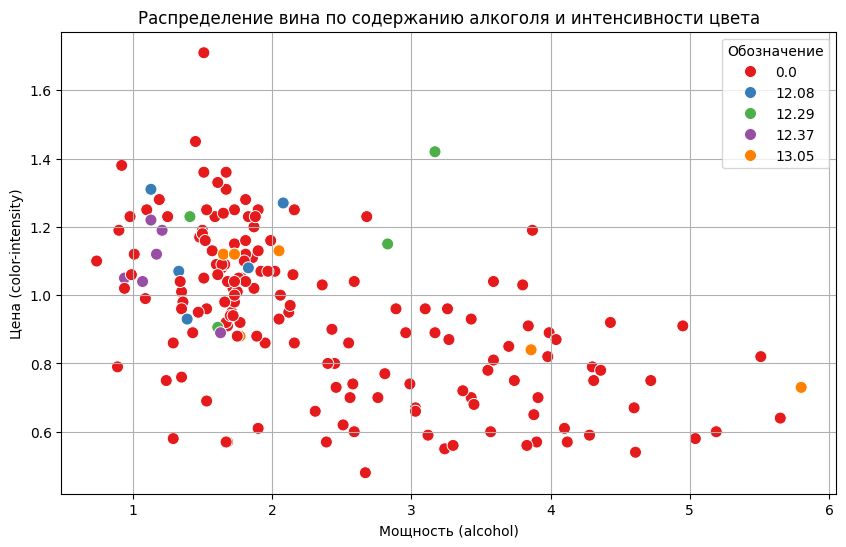

In [241]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="alcohol", y="color-intensity", hue="cultivar", palette="Set1", s=75)

plt.title("Распределение вина по содержанию алкоголя и интенсивности цвета")
plt.xlabel("Мощность (alcohol)")
plt.ylabel("Цена (color-intensity)")
plt.legend(title="Обозначение")
plt.grid(True)
plt.show()

5. Проведите кластеризацию набора данных из двух признаков с помощью алгоритмов, указанных в индивидуальном задании, для случая, когда количество кластеров равно количеству классов в исходном наборе (с учетом корректировки). В случае отсутствия сходимости алгоритма измените аргументы по умолчанию или используйте для кластеризации случайную выборку из набора данных.

In [242]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [243]:
def plot_cluster(X, y):
    # Визуализация кластеров
    plt.figure(figsize=(10, 6))
    clusters = np.unique(y)
    for cluster in clusters:
        # Индексы строк для данного кластера
        row_ix = np.where(y == cluster)[0]
        # Диаграмма рассеяния для кластера, используем iloc для индексации строк
        plt.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1], s=100, label=f"Cluster {cluster}")

    plt.title("Распределение кластеров")
    plt.xlabel("alcohol")
    plt.ylabel("color-intensity")
    plt.legend()
    plt.grid(True)

In [244]:
X = df.iloc[:, [0, 1]]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

n_clusters = len(df["cultivar"].value_counts())
n_clusters

5

##K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


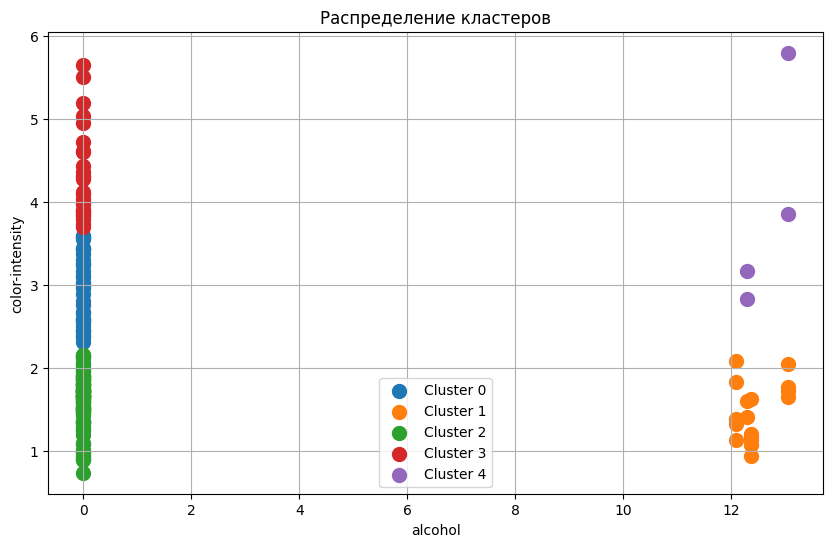

In [245]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)
kmeans_labels = kmeans.predict(X)

plot_cluster(X, kmeans_labels)

##Agglomerative Clustering

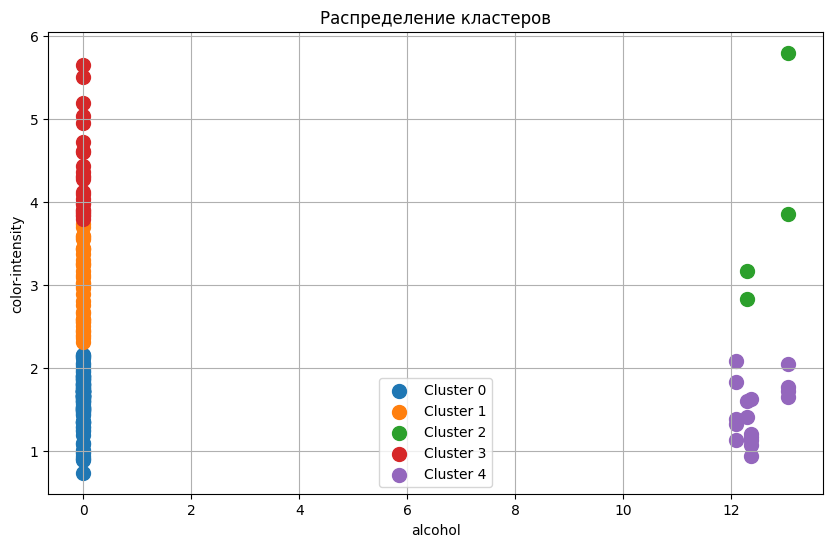

In [246]:
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo_labels = agglo.fit_predict(X)

plot_cluster(X, agglo_labels)

##DBSCAN

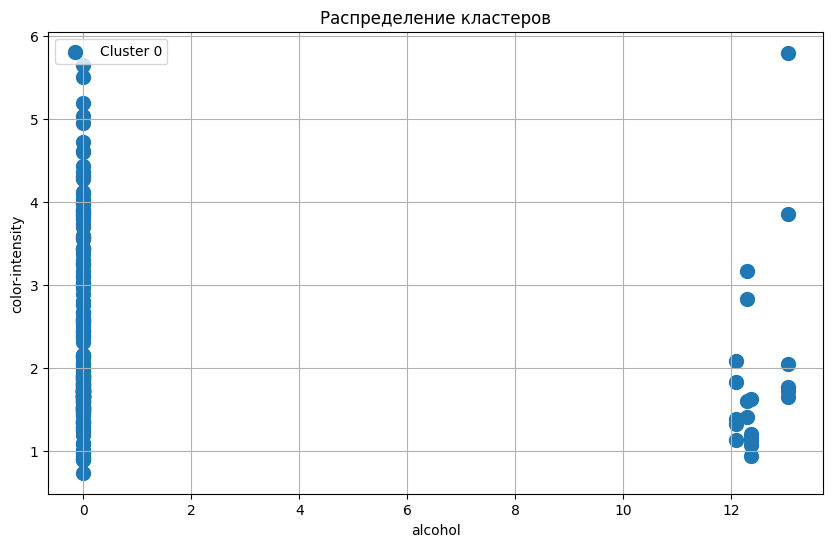

In [247]:
dbscan = DBSCAN(eps=2000, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

plot_cluster(X, dbscan_labels)

##Gaussian Mixture Model

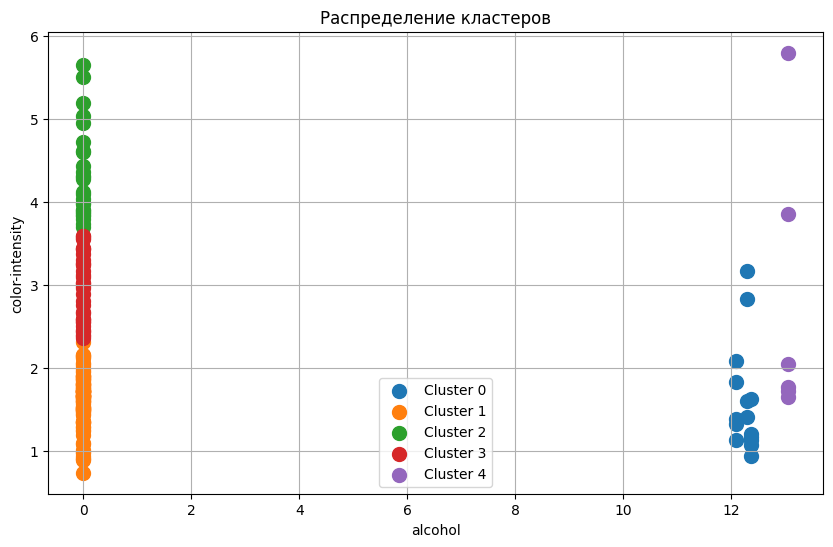

In [248]:
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm_labels = gmm.fit_predict(X)

plot_cluster(X, gmm_labels)

6. Для каждого из алгоритмов кластеризации, указанных в индивидуальном задании, постройте матрицу сопряженности, используя функцию contingency_matrix() из scikit-learn, и найдите значения мер качества кластеризации, указанные в индивидуальном задании, на основании данных в матрице сопряженности, не используя другие функции из scikit-learn или других фреймворков.

In [249]:
from sklearn.metrics.cluster import contingency_matrix

In [250]:
def conditional_entropy(contingency):
  total = np.sum(contingency)
  cluster_probs = np.sum(contingency, axis=0) / total
  entropy = 0
  for j in range(contingency.shape[1]):
    col = contingency[:, j]
    col_prob = col / np.sum(col)
    for i in range(contingency.shape[0]):
      if col[i] != 0:
        entropy -= cluster_probs[j] * col_prob[i] * np.log2(col_prob[i])
  return entropy

In [251]:
def pairwise_measures(contingency):
  if contingency.size == 0:
    return 0, 0, 0, 0  # Возвращаем нули, если матрица пуста

  TP = np.sum(np.diagonal(contingency))

  FN = 0
  for i in range(contingency.shape[0]):
    FN += np.sum(contingency[i, :]) - contingency[i, i]

  FP = 0
  for j in range(contingency.shape[1]):
    FP += np.sum(contingency[:, j]) - contingency[j, j]

  total = np.sum(contingency)
  TN = total - TP - FN - FP

  return TP, FN, FP, TN

In [252]:
def rand_index(contingency):
  if contingency.size == 0:
    return 0  # Возвращаем 0, если матрица пуста

  TP, FN, FP, TN = pairwise_measures(contingency)
  return (TP + TN) / (TP + FN + FP + TN)

In [253]:
true_labels = df["cultivar"].values
# KMeans
kmeans_contingency = contingency_matrix(true_labels, kmeans_labels)
kmeans_entropy = conditional_entropy(kmeans_contingency)
print("KMeans:")
print(f"  Условная энтропия: {kmeans_entropy:.4f}")

kmeans_TP, kmeans_FN, kmeans_FP, kmeans_TN = pairwise_measures(kmeans_contingency)
print(f"  TP: {kmeans_TP}, FN: {kmeans_FN}, FP: {kmeans_FP}, TN: {kmeans_TN}")

kmeans_rand = rand_index(kmeans_contingency)  # Передаем только матрицу сопряженности
print(f"  Индекс Rand: {kmeans_rand:.4f}")

KMeans:
  Условная энтропия: 0.2043
  TP: 44, FN: 134, FP: 134, TN: -134
  Индекс Rand: -0.5056


In [254]:
# AgglomerativeClustering
agglomerative_contingency = contingency_matrix(true_labels, agglo_labels)
agglomerative_entropy = conditional_entropy(agglomerative_contingency)
print("\nAgglomerativeClustering:")
print(f"  Условная энтропия: {agglomerative_entropy:.4f}")

agglomerative_TP, agglomerative_FN, agglomerative_FP, agglomerative_TN = pairwise_measures(agglomerative_contingency)
print(f"  TP: {agglomerative_TP}, FN: {agglomerative_FN}, FP: {agglomerative_FP}, TN: {agglomerative_TN}")

agglomerative_rand = rand_index(agglomerative_contingency)
print(f"  Индекс Rand: {agglomerative_rand:.4f}")



AgglomerativeClustering:
  Условная энтропия: 0.2043
  TP: 99, FN: 79, FP: 79, TN: -79
  Индекс Rand: 0.1124


In [255]:
# DBSCAN (с обработкой выбросов)
non_outliers = dbscan_labels != -1
dbscan_labels_no_outliers = dbscan_labels[non_outliers]
true_labels_no_outliers = true_labels[non_outliers]

dbscan_contingency = contingency_matrix(true_labels_no_outliers, dbscan_labels_no_outliers)
dbscan_entropy = conditional_entropy(dbscan_contingency)
print("\nDBSCAN:")
print(f"  Условная энтропия: {dbscan_entropy:.4f}")

if dbscan_contingency.shape[0] > 1 and dbscan_contingency.shape[1] > 1:  # Проверка размера матрицы
  dbscan_TP, dbscan_FN, dbscan_FP, dbscan_TN = pairwise_measures(dbscan_contingency)
  print(f"  TP: {dbscan_TP}, FN: {dbscan_FN}, FP: {dbscan_FP}, TN: {dbscan_TN}")

  dbscan_rand = rand_index(dbscan_contingency)
  print(f"  Индекс Rand: {dbscan_rand:.4f}")
else:
  print("  Невозможно вычислить метрики: DBSCAN не сформировал достаточное количество кластеров.")


DBSCAN:
  Условная энтропия: 0.7573
  Невозможно вычислить метрики: DBSCAN не сформировал достаточное количество кластеров.


In [256]:
# GaussianMixture
gaussian_contingency = contingency_matrix(true_labels, gmm_labels)
gaussian_entropy = conditional_entropy(gaussian_contingency)
print("\nGaussianMixture:")
print(f"  Условная энтропия: {gaussian_entropy:.4f}")

gaussian_TP, gaussian_FN, gaussian_FP, gaussian_TN = pairwise_measures(gaussian_contingency)
print(f"  TP: {gaussian_TP}, FN: {gaussian_FN}, FP: {gaussian_FP}, TN: {gaussian_TN}")

gaussian_rand = rand_index(gaussian_contingency)
print(f"  Индекс Rand: {gaussian_rand:.4f}")


GaussianMixture:
  Условная энтропия: 0.1319
  TP: 6, FN: 172, FP: 172, TN: -172
  Индекс Rand: -0.9326


7. Определите алгоритм кластеризации, оптимальный с точки зрения меры качества кластеризации, указанной в индивидуальном задании.

###K-Means: 0.5056
###Agglomerative Clustering: 0.1124
###DBSCAN: не удалось высчитать
###Gaussian Mixture Model (GMM): 0.9326
По индексу Rand самый лучший алгоритм - Agglomerative Clustering, т.к. наша база данных сильно отличается от нормальной кластеризованной.

8. Для оптимального алгоритма кластеризации из предыдущего пункта визуализируйте области принятия решения и набор данных в виде точек на плоскости с координатами, соответствующими двум признакам, отображая точки различных кластеров разными цветами. Подпишите оси и рисунок, создайте легенду набора данных.

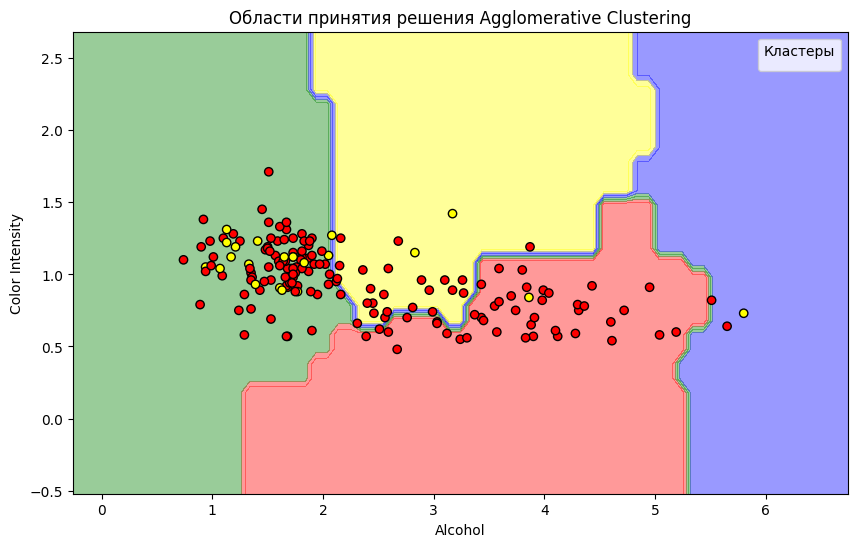

In [257]:
from matplotlib.colors import ListedColormap

# Agglomerative Clustering
X = df[["alcohol", "color-intensity"]]
agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative_labels = agglomerative.fit_predict(X)

# Создаем сетку точек для визуализации областей принятия решения
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Получаем предсказания для каждой точки сетки
Z = agglomerative.fit_predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Создаем цветовую карту
cmap = ListedColormap(['red', 'green', 'blue', 'yellow'])

# Визуализируем области принятия решения
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)

# Визуализируем набор данных
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=true_labels, cmap=cmap, edgecolor='k')

# Настраиваем график
plt.title("Области принятия решения Agglomerative Clustering")
plt.xlabel("Alcohol")
plt.ylabel("Color Intensity")
plt.legend(title="Кластеры")
plt.show()